# О проекте: анализ ресторанов Москвы

Мой проект посвящен сбору и исследованию данных по ресторанам в Москве. Сначала я ищу нужные мне рестораны и скрэплю с TripAdvisor, потом получаю полную информацию о них через API, а далее провожу анализ данных различными методами (pandas, numpy, визуализация, геоданные, графы, машинное обучение, SQL, регулярные выражения и пр.). Проект содержит практически все технологии, которые мы проходили в рамках курса.

# 0. Импорт библиотек

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl  
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets 
import warnings
warnings.filterwarnings('ignore')
import duckdb 
import requests
import time
!pip install apify-client # загружаем API клиент
from apify_client import ApifyClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error as MAE
!pip install catboost # скачиваем
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as ltb
import folium
import jinja2
import branca.colormap as cm
from folium.plugins import HeatMap
import urllib.request
from urllib.parse import urlencode
import re
from PIL import Image
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Веб-скрэппинг с помощью Selenium

Не перезапускайте эту секцию, пожалуйста, т.к. иногда скрэппинг может не работать, т.к. сайт активно защищается от скрэппинга.

Я работала в коллабе, поэтому мне нужно было подгрузить на сервер драйвер браузера. Код для этого я взяла отсюда:
https://github.com/googlecolab/colabtools/issues/3347#:~:text=%25%25shell%0Asudo%20apt,pip%20install%20selenium

In [23]:
### FROM (https://github.com/googlecolab/colabtools/issues/3347#:~:text=%25%25shell%0Asudo%20apt,pip%20install%20selenium)
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,354 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,776 kB]
Get:14 http://ar

Мы работаем на странице ресторанов в Москве на TripAdvisor (https://www.tripadvisor.ru/Restaurants-g298484-Moscow_Central_Russia.html).

In [24]:
# установка драйвера
from selenium import webdriver
from selenium.webdriver.common.by import By

URL = "https://google.com"

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(
    options=options
)
### END FROM

Далее написан непосредственно скрэппинг и продвинутый поиск по базе ресторанов Москвы. Юзер указывает необходимые параметры, и функция поиска скрэпит 3 лучших ресторана с этими параметрами из базы данных TripAdvisor. Из-за сложности html-структуры сайта TripAdvisor, скрэпить используя имя не представлялось возможным (поиск просто ничего не находил). В связи с этим мною использовались ID кнопок. Я также посчитала универсальную формулу скрэпинга через XPATH ресторанов. Сайт защищается от скрэппинга и имеет сложную структуру, поэтому есть определенные технические трудности, и возможны перебои работы. Тем не менее, функция помогла мне заскрэпить 1000 имен ресторанов.

Функция дает возможность указать различные желаемые параметры и получить топ-3 (или n  в общем случае) ресторана с наивысшим рейтингом, соответствующих запросу, а также ссылки на них.
### Пригодный формат данных для функции:


1.   delivery: str, возможные опции: "Доставка" / None
2.   reservation: str, возможные опции: "Бронирование" / None
3.   time: str, возможные опции: "Завтрак" / "Обед" / "Ужин" / None
4.   price_ranges: list, возможные опции внутри списка (str): "Дешевле", "Средне", "Дорого" / None
5.   cuisines: list, возможные опции внутри списка (str): "Европейская кухня", "Русская кухня", "Итальянская кухня", "Азиатская кухня", "Израильская кухня", "Фастфуд".
6.   restrictions: str, возможные опции: "Вегетарианская еда" / None
7.   districts: list, возможные опции внутри списка (str): "ТТК", "ЦАО", "ВАО", "ЗАО", "СЗАО", "СВАО", "САО", "ЮВАО", "ЮЗАО", "ЮАО" / None
8. n = int, кол-во ресторанов на выдаче, по умолчанию для юзера будет 3 (больше будет нагружать API).


In [18]:
# функция, находящая нужную кнопку по ID и нажимающая на неё

def repetative(browser, ID): 
    webElement = browser.find_element(By.ID, ID)
    browser.execute_script("arguments[0].click();", webElement)
    time.sleep(5)

#функция поиска

def user_search(browser, delivery = None, reservation = None, time_d = None, price_ranges = None, cuisines = None, restrictions = None, districts = None, n = 3):

    # создаем словари, сопоставляя каждой кнопке её ID

    times = { 'Завтрак': 'checkbox_42', 'Обед': 'checkbox_44', 'Ужин': 'checkbox_45' } 
    prices = { 'Дешевле': 'checkbox_50', 'Средне': 'checkbox_51', 'Дорого': 'checkbox_52' }
    kitchens = {
                'Европейская кухня': 'checkbox_56',
                'Русская кухня': 'checkbox_57',
                'Итальянская кухня': 'checkbox_105',
                'Азиатская кухня': 'checkbox_63',
                'Израильская кухня': 'checkbox_99',
                'Фастфуд': 'checkbox_178'
               }
    areas = {
             'ТТК': 'checkbox_461',
             'ЦАО': 'checkbox_471',
             'ВАО': 'checkbox_352',
             'ЗАО': 'checkbox_363',
             'СЗАО': 'checkbox_446',
             'СВАО': 'checkbox_445',
             'САО': 'checkbox_444',
             'ЮВАО': 'checkbox_478',
             'ЮЗАО': 'checkbox_479',
             'ЮАО': 'checkbox_484'
            }


    # запускаем драйвер

    link = 'https://www.tripadvisor.ru/Restaurants-g298484-Moscow_Central_Russia.html'
    driver.get(link)
    time.sleep(5) # необходима задержка, т.к. иначе сайт не успеет прогрузиться

    # нажимаем на кнопки

    if delivery == 'Доставка': 
        delivery_ID = 'checkbox_15'
        repetative(browser, delivery_ID)
        
    if reservation == 'Бронирование':
        reservation_ID = 'checkbox_18'
        repetative(browser, reservation_ID)
        
    if time_d in times:
        time_ID = times[time_d]
        repetative(browser, time_ID)
        
    if price_ranges is not None:
        for price_range in price_ranges:
            price_range_ID = prices[price_range]
            repetative(browser, price_range_ID)

    if cuisines is not None:
        for cuisine in cuisines:
            cuisine_ID = kitchens[cuisine]
            repetative(browser, cuisine_ID)
        
    if restrictions == 'Вегетарианская еда':
        restrictions_ID = 'checkbox_298'
        repetative(restrictions_ID)
        
    if districts is not None:
        for district in districts:
            district_ID = areas[district]
            repetative(browser, district_ID)

    # эта часть необходима для скрэппинга больших объемов ресторанов 
    
    urls = []
    names = []

    for i in range(1, n+1): # переключение страницы
        if i % 30 == 1 and i > 1:
            driver.get(f'https://www.tripadvisor.ru/RestaurantSearch-g298484-oa{i - 1}-Moscow_Central_Russia.html#EATERY_LIST_CONTENTS')
            time.sleep(5)

        j = i - 30 * ((i - 1) // 30) #считывание имени ресторана
        cnt = (j + 1)  // 5 
        if i < 31:
            url = f'/html/body/div[4]/div[3]/div[2]/div[2]/div[2]/div[3]/div[2]/div/div[6]/div[3]/div[5]/div[1]/div/div/div[{j + cnt}]/div/div[1]/div[2]/div[1]/div/span/a'
        else:
              url = f'/html/body/div[4]/div[3]/div/div[2]/div[2]/div[3]/div[2]/div/div[6]/div[3]/div[5]/div[1]/div/div/div[{j + cnt}]/div/div[1]/div[2]/div[1]/div/span/a'
        webElement1 = driver.find_element(By.XPATH, url) 
        names.append(webElement1.text)
        webURL = webElement1.get_attribute('href') # получение ссылки на ресторан
        urls.append(webURL)  

    api_list = [] # сохранение в список
    for url in urls:
        url_dict = {}
        url_dict['url'] = url
        api_list.append(url_dict)
    return names, api_list # функция возвращает список ресторанов и ссылок на них

In [19]:
names, api_list = user_search(driver, time_d = 'Обед', price_ranges = ['Дешевле'], cuisines = ['Итальянская кухня','Азиатская кухня'], districts=['ЮЗАО'])
names # пример использования

['1. Кафе Пикассо', '2. Хатимаки Ясенево', '3. Хью Бар']

In [ ]:
api_list

[{'url': 'https://www.tripadvisor.ru/Restaurant_Review-g298484-d6501816-Reviews-Cafe_Picasso-Moscow_Central_Russia.html'},
 {'url': 'https://www.tripadvisor.ru/Restaurant_Review-g298484-d20046762-Reviews-Hatimaki_Yasenevo-Moscow_Central_Russia.html'},
 {'url': 'https://www.tripadvisor.ru/Restaurant_Review-g298484-d23086535-Reviews-Hyu_Bar-Moscow_Central_Russia.html'}]

In [21]:
names1, api_list1 = user_search(driver, time_d = 'Завтрак', price_ranges = ['Дешевле'], cuisines = ['Израильская кухня','Русская кухня'], districts=['ЦАО'])
names1 # пример использования

['1. Грабли Food Bar', '2. Столовая 57', '3. Грабли']

#2. Работа с API

Далее я подгружаю полученные ссылки в TripAdvisor API. Я использовала его неофициальную версию Apify, т.к. для использования официальной необходима иностранная кредитная карта :(

Ключ дает ограниченное кол-во запросов, при превышении нужно будет создать новый аккаунт и получить API Token. 

Код из следующей ячейки частично взят из гайда API: https://apify.com/maxcopell/free-tripadvisor/api

Функция на вход принимает ссылки в формате, необходимом для API: список словарей. Мы получаем этот список из функции продвинутого поиска.

In [ ]:
def api(api_urls, token):
    apify_client = ApifyClient(token)

    # пишем запрос в базу API
    
    run_input = {
        'startUrls': api_urls,
        "maxItems": 100,
        "maxReviews": 10,
        "language": "en",
        "currency": "USD",
        "proxyConfiguration": { "useApifyProxy": True },
    }

    run = apify_client.actor("maxcopell/free-tripadvisor").call(run_input=run_input) # проводим запрос

    items = []
    for item in apify_client.dataset(run["defaultDatasetId"]).iterate_items(): # сохраняем результаты
        items.append(item)
    return items

In [ ]:
user_token = 'apify_api_jFOvfTgbK7ysfGlnY1FCB13PBohDrv2znyth'
user_result = api(api_list, user_token)

In [ ]:
df_user = pd.DataFrame.from_records(user_result) # получаем информацию по 3 ресторанам и переводим их в датафрейм
df_user = df_user.drop(columns = ['image', 'hours', 'rankingDenominator', 'reviews', 'mealTypes']) # дропаем ненужные колонки
df_user

id        type               name awards rankingPosition priceLevel  \
0   6501816  RESTAURANT       Cafe Picasso     []            1397          $   
1  20046762  RESTAURANT  Hatimaki Yasenevo     []            1623          $   
2  23086535  RESTAURANT            Hyu Bar     []            2842          $   

     category  rating  isClosed  isLongClosed  ...  \
0  restaurant     4.5     False         False  ...   
1  restaurant     5.0     False         False  ...   
2  restaurant     4.5     False         False  ...   

                                          address                 email  \
0  Miklukho-Maklaya St., 15, Moscow 117198 Russia  kafe.picasso@mail.ru   
1    Novoyasenevskiy Ave, 9, Moscow 117588 Russia   service@hatimaki.ru   
2    Profsoyuznaya St., 118, Moscow 117437 Russia            hi@hyu.bar   

                                             cuisine    dietaryRestrictions  \
0  [Italian, Mexican, European, Asian, Middle Eas...  [Vegetarian Friendly]   
1    [Italian, Chinese, Japanese, American, Russian]                     []   
2  [Italian, American, Bar, European, Pub, Beer r...                     []   

    latitude  longitude                                             webUrl  \
0   55.65305  37.505997  https://www.tripadvisor.com/Restaurant_Review-...   
1  55.610325  37.536453  https://www.tripadvisor.com/Restaurant_Review-...   
2  55.636612  37.521564  https://www.tripadvisor.com/Restaurant_Review-...   

                                       website  \
0                  http://www.cafepicasso.org/   
1  http://www.hatimaki.ru/tripadvisor_yasenevo   
2     http://www.instagram.com/hyu.bar.moscow/   

                              rankingString numberOfReviews  
0  #1,397 of 15,850 places to eat in Moscow              30  
1  #1,623 of 15,850 places to eat in Moscow               9  
2  #2,842 of 15,850 places to eat in Moscow               7  

[3 rows x 21 columns]

# 3. Выгрузка данных о 1000 лучших ресторанах Москвы


В этом разделе я выгружу через API 1000 ресторанов в Москве с наивысшим рейтингом для дальнейшего анализа. Сначала я их нашла через функцию user_search, далее я воспользовалась написанной выше функцией для API и сохранила полученный файл в csv в облако. В дальнейшем файл будет подгружаться оттуда, т.к. иначе при любом перезапуске ноутбука у меня бы тратилось 1000 запросов по ключу API. Во избежание этого код с доступом к API теперь закомментирован.

In [ ]:
#names_100, api_list_100 = user_search(driver, n = 1000) # находим 1000 ресторанов с наивысшим рейтингом

Процесс завершен на 100
Процесс завершен на 200
Процесс завершен на 300
Процесс завершен на 400
Процесс завершен на 500
Процесс завершен на 600
Процесс завершен на 700
Процесс завершен на 800
Процесс завершен на 900
Процесс завершен на 1000


In [ ]:
#admin_token = 'apify_api_JPvV9lfAnmWQBwVdYvf9pSiOzo3VUE3UMewm' 
#admin_result = api(api_list_100[0:99], admin_token)

In [ ]:
#for i in range(1, 10): # к сожалению, API разрешает максимум 100 запросов за раз, поэтому проходимся циклом
    #admin_result = admin_result.append(api(api_list_100[100 * i: 100 * i + 100], admin_token))

# 4. Pandas, Visualisation, NumPy

Будем работать с полученным нами датасетом 1000 ресторанов Москвы с наивысшим рейтингом. Сначала обработаем его, а потом посмотрим на разные графики.

## 4.1 Препроцессинг

In [3]:
!gdown 1snY6CMOFULrJ2VCivCKIGVWxfDlaa2Np # скачивание файла с гугл-диска

Downloading...
From: https://drive.google.com/uc?id=1snY6CMOFULrJ2VCivCKIGVWxfDlaa2Np
To: /content/Restaurants_1000.csv
100% 522k/522k [00:00<00:00, 5.87MB/s]


In [4]:
table1 = pd.read_csv('Restaurants_1000.csv', sep=';',  encoding='cp1252', index_col='id') # парсинг в таблицу
table1 = table1.iloc[:-1]

In [5]:
# обработка пропусков

strings = table1.select_dtypes(include=['object'])
table1[strings.columns] = table1[strings.columns].fillna('Not stated') 
numbers = table1.select_dtypes(include=['float64'])
table1[numbers.columns] = table1[numbers.columns].fillna(float('NaN'))
table1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 997 entries, 786405.0 to 3770594.0
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   997 non-null    object 
 1   numberOfReviews        997 non-null    float64
 2   phone                  997 non-null    object 
 3   priceLevel             997 non-null    object 
 4   rankingDenominator     997 non-null    float64
 5   rankingPosition        997 non-null    float64
 6   rankingString          997 non-null    object 
 7   rating                 997 non-null    object 
 8   type                   997 non-null    object 
 9   webUrl                 997 non-null    object 
 10  website                997 non-null    object 
 11  address                997 non-null    object 
 12  category               997 non-null    object 
 13  cuisine/0              997 non-null    object 
 14  cuisine/1              997 non-null    obje

In [6]:
# переводим в строку для дальнейшей обработки

table1['priceLevel'] = table1['priceLevel'].astype("string") 
table1['priceLevel']

id
786405.0      $$ - $$$
11549325.0    $$ - $$$
10005584.0    $$ - $$$
798767.0          $$$$
13799938.0    $$ - $$$
                ...   
14761213.0    $$ - $$$
6591687.0     $$ - $$$
12709053.0    $$ - $$$
10594215.0        $$$$
3770594.0     $$ - $$$
Name: priceLevel, Length: 997, dtype: string

Создаем ценовой признак, переводя изначальные символы TripAdvisor вида '$' в шкалу 1-3, где 1 - дешево, а 3 - дорого.

In [7]:
# словарь значений

prices = { 
    'Not stated' : float("NaN"),
    '$' : 1,
    '$$ - $$$' : 2,
    '$$$$' : 3
}

table1['price'] = table1['priceLevel'].apply(lambda x: prices[x]) 

Создаем признак удаленности от центра. Для этого возьмем координаты ресторанов и посчитаем их расстояние от центра Москвы (возьмем координаты Кремля за центр).

In [8]:
coordinate_1 = (table1['latitude'] - 55.751999) * np.pi / 180  # переводим в радианы
coordinate_2 = (table1['longitude'] - 37.617734) * np.pi / 180
table1['dist_center'] = np.sqrt((coordinate_1) ** 2 + (coordinate_2) ** 2) * 6372.795 # считаем евклидово расстояние и домножаем на константу

Также закодируем признак с дополнительными пищевыми опциями таким образом: количество пищевых опций будет являться значением признака (максимум 3).

In [9]:
# переводим в строку

table1['dietaryRestrictions/0'] = table1['dietaryRestrictions/0'].astype("string") 
table1['dietaryRestrictions/1'] = table1['dietaryRestrictions/1'].astype("string")
table1['dietaryRestrictions/2'] = table1['dietaryRestrictions/2'].astype("string")

 # создаем маски

table1['diet_options_enc'] = 0
ns_mask0 = table1['dietaryRestrictions/0'] != 'Not stated'
ns_mask1 = table1['dietaryRestrictions/1'] != 'Not stated'
ns_mask2 = table1['dietaryRestrictions/2'] != 'Not stated'

 # присваиваем нумерацию
 
table1['diet_options_enc'][ns_mask0] = 1
table1['diet_options_enc'][ns_mask0 * ns_mask1] = 2
table1['diet_options_enc'][ns_mask0 * ns_mask1 * ns_mask2] = 3

И наконец создадим признак = кол-во кухонь в одном ресторане.

In [10]:
# выбираем все колонки с кухнями и делаем маски

table_cuisine = table1.iloc[:, 13:21] 
table_cuisine[table_cuisine != 'Not stated'] = 1
table_cuisine[table_cuisine == 'Not stated'] = 0

# считаем, сколько кухонь по строчке

table1['num_cuisine'] = np.sum(table_cuisine, axis=1) 
table1['num_cuisine']

id
786405.0      6.0
11549325.0    4.0
10005584.0    7.0
798767.0      4.0
13799938.0    5.0
             ... 
14761213.0    6.0
6591687.0     4.0
12709053.0    6.0
10594215.0    6.0
3770594.0     6.0
Name: num_cuisine, Length: 997, dtype: float64

Теперь наши данные прошли первичную обработку и можно рисовать графики!

## 4.2 Визуализация

Посмотрим, сколько ресторанов попадают в разные ценовые категории. Как можно заметить, в основном все попадают в средний диапазон цен.

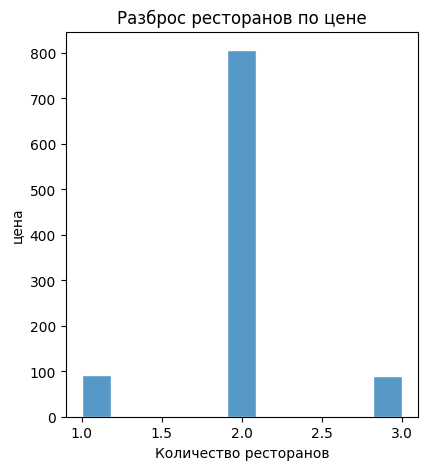

In [11]:
# рисуем гистограмму

figure, axes = plt.subplots(figsize = (10, 5)) 


sub1 = plt.subplot(1, 2, 1) 
sub1.set_title('Разброс ресторанов по цене')
sns.set(style="darkgrid")
ax1 = sns.histplot(table1['price'])
ax1.set(xlabel='Количество ресторанов', ylabel='цена')


plt.show()

Теперь рисуем совместный график в координатах "расстояние до центра" - "позиция рейтинга", чтобы посмотреть взаимосвязь параметров. Уберем выбросы по расстоянию. Можем заметить, что рестораны с наивысшим рейтингом практически все находятся в самом центре города. Однако, есть центральные рестораны с относительно низким рейтингом. Это объяснимо в том числе тем, что мы брали выборку ресторанов с наивысшим рейтингом, т.е. даже относительно плохой рейтиг == не ниже 4 в данном датасете.

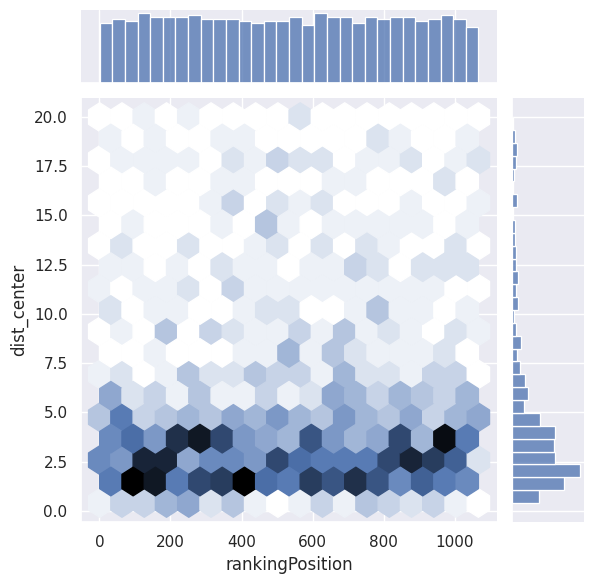

In [12]:
sns.jointplot(x=table1['rankingPosition'], y=table1['dist_center'][table1['dist_center'] <= 20], kind='hex', marginal_kws=dict(bins=30))

Теперь построим продвинутый график с интерактивными элементами. Посмотрим на взаимосвязь позиции в рейтинге и расстояния до центра по каждой кухне отдельно. Цвет точек будет обозначать ценовую категорию ресторана. Также, возможно задать минимальное количество отзывов на ресторан.

In [13]:
# функция графика

def plot_cuisine(cuisine, min_num_reviews):
    plt.clf() # очищаем график

    # выбираем нужные нам признаки
    
    x = table1[(table1['cuisine/0'] == cuisine) * (table1['numberOfReviews'] >= min_num_reviews)]['rankingPosition'] 
    y = table1[(table1['cuisine/0'] == cuisine) * (table1['numberOfReviews'] >= min_num_reviews)]['dist_center']
    sns.jointplot(table1, x=x, y=y, hue='price', palette='flare') # рисуем
    plt.show()

# пишем интерактивные элементы

# выбор кухни

cuisine_selector = ipywidgets.Dropdown( 
    options=table1['cuisine/0'].unique(),
    index=0,
    value='European',
    layout={'width': '800px'},
    continuous_update=False)

# выбор минимального кол-ва отзывов

num_reviews_slider = ipywidgets.IntSlider( 
    value=70,
    min=1, 
    max=1000, 
    layout={'width': '800px'},
    step=10, 
    continuous_update=False)

# настройка графика

ipywidgets.interact( 
    plot_cuisine,
    cuisine=cuisine_selector,
    min_num_reviews=num_reviews_slider
)

interactive(children=(Dropdown(description='cuisine', layout=Layout(width='800px'), options=('Cafe', 'European…

<function __main__.plot_cuisine(cuisine, min_num_reviews)>

Теперь нарисуем совместный график количества отзывов и отдаленности от центра, при этом покрасим точки в ценовой уровень ресторана. Определенный тренд выделить трудно, кажется, что большинство ресторанов получают до 500 отзывов при любой локации. Можно заметить смещенность датасета к центральным ресторанам, что кореллирует со смещенностью в сторону высокого рейтинга.

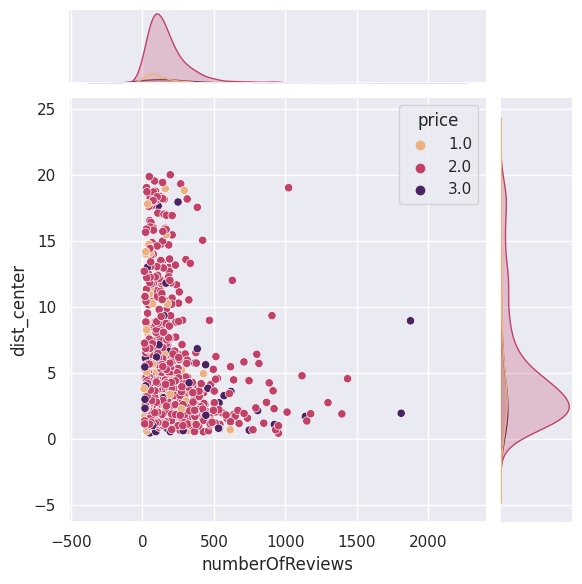

In [14]:
ax2 = sns.jointplot(table1, x=table1['numberOfReviews'][table1['numberOfReviews'] < 2000], y=table1['dist_center'][table1['dist_center'] <= 20], hue='price', palette='flare')

Построим столбчатую диаграмму разброса цен по разным кухням. Самой дорогой в среднем является современная кухня (Contemporary), следом за ней идут морепродукты (Seafood) и китайская, французская, гриль. Самой дешевой является Фастфуд и Вьетнамская кухня.

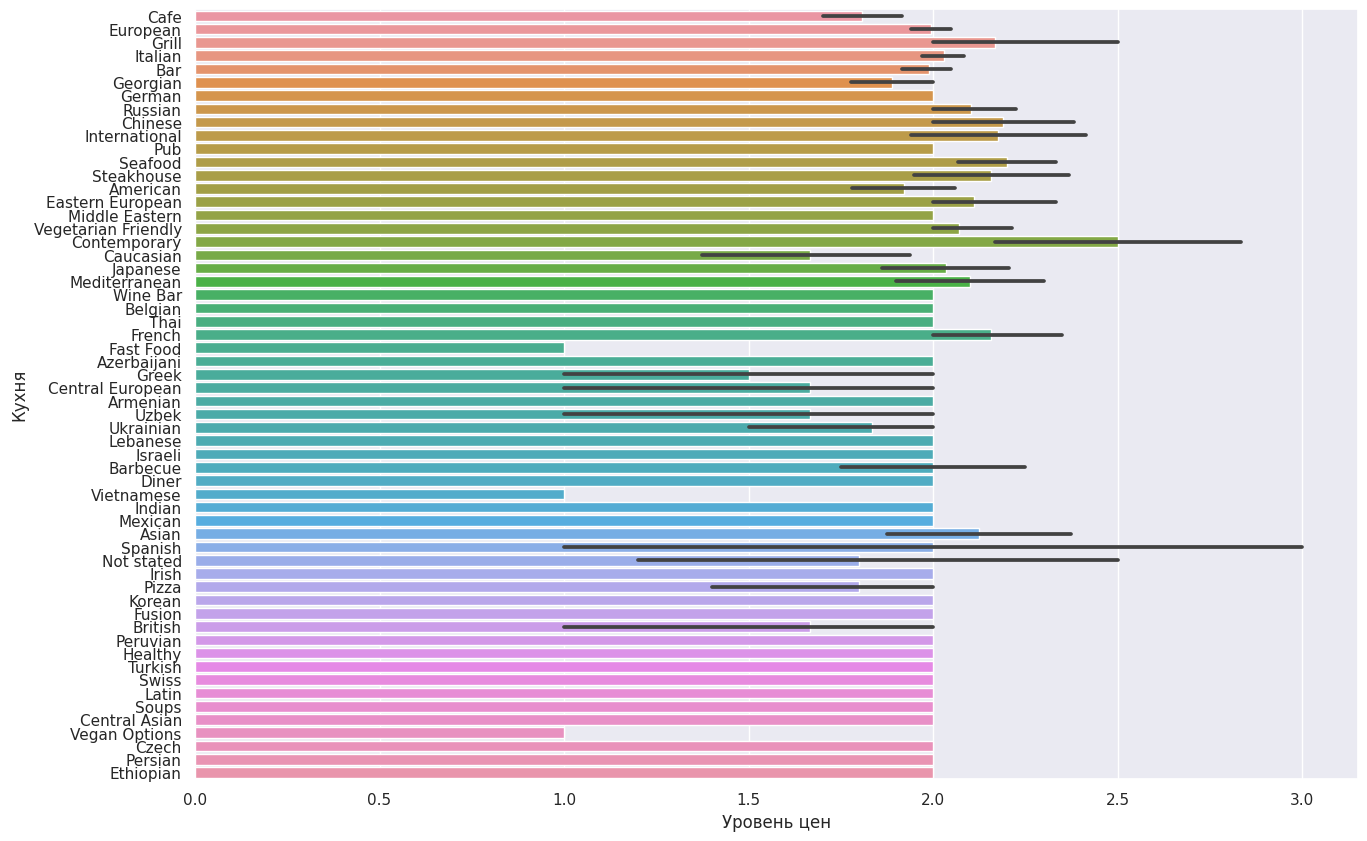

In [15]:
figure, axes = plt.subplots(figsize = (15, 10))
ax1 = sns.barplot(table1, x = table1['price'], y = table1['cuisine/0'])
ax1.set(xlabel='Уровень цен', ylabel='Кухня')
plt.show()

Теперь я хочу создать категорию справедливости ценовой политики ресторана. Для этого мы создадим 3 ярлыка: Underpriced == цены ниже чем в среднем у ресторанов этой кухни, а позиция в рейтине выше; Overpriced == наоборот ; Fairly priced == отклонение цены и рейтинга от среднего по группе кухни в одну сторону.

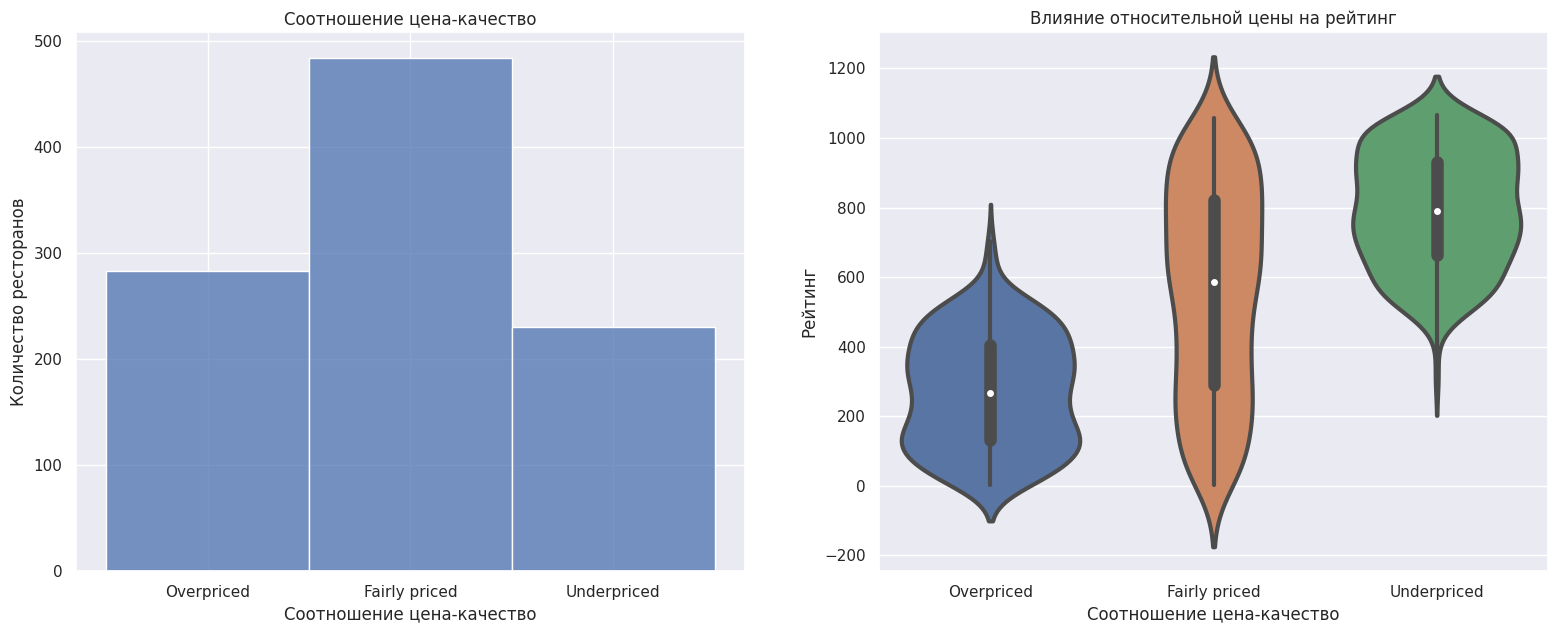

In [16]:
# готовим данные

table1['mean_price_by_cuisine'] = table1.groupby('cuisine/0')['price'].transform('mean') # считаем среднюю цену по группе кухни
table1['mean_ranking_by_cuisine'] = table1.groupby('cuisine/0')['rankingPosition'].transform('mean') # считаем среднюю позицию в рейтинге по группе кухни
mask1 = table1['rankingPosition'] >= table1['mean_ranking_by_cuisine'] # маска по рейтингу
mask2 = table1['price'] >= table1['mean_price_by_cuisine'] # маска по цене
table1['label'] = 'Fairly priced'
table1['label'][~mask1 * mask2] = 'Overpriced' # создаем ярлыки
table1['label'][mask1 * ~mask2] = 'Underpriced'

# рисуем графики

figure = plt.subplots(figsize=(19, 7)) 


sub1 = plt.subplot(1, 2, 1) # гистограмма распредения ресторанов по ярлыкам
sub1.set_title('Соотношение цена-качество')
ax1 = sns.histplot(table1['label'])
ax1.set(ylabel='Количество ресторанов', xlabel='Соотношение цена-качество')


sub1 = plt.subplot(1, 2, 2) # violinplot для рейтинга по ярлыкам
sub1.set_title('Влияние относительной цены на рейтинг')
ax2 = sns.violinplot(x=table1["label"], y=table1['rankingPosition'], linewidth=3)
ax2.set(ylabel='Рейтинг', xlabel='Соотношение цена-качество')
plt.show()

В основном рестораны справедливо оценивают себя, хотя достаточно и тех, кто выше или ниже рынка. Это связано с дополнительныим факторами ресторанов, влияющих на цены (локация, маркетинг и пр.). В среднем оверпрайснутые рестораны - это рестораны с высоким рейтингом, и наоборот.


Теперь переходим к следующему этапу работы с данными.

# 5. Машинное обучение: регрессии и дополнительные технологии бустинга

## 5.1. Работа с признаками (в том числе с категориальными)

Делим на трейн и тест. В данном анализе мы будем предсказывать с помощью вида кухни, удаленности от центра, кол-ва отзывов и других признаков позицию ресторана в рейтинге.

In [27]:
X = table1[['name', 'price', 'dist_center', 'num_cuisine', 'diet_options_enc', 'cuisine/0', 'numberOfReviews']] # выбираем признаки
y = table1['rankingPosition'] # таргет
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=513, shuffle=True)

Для дальнейшей работы нам понадобится закодированный признак по кухням. Кодировать будем счетчиком, т.к. OneHotEncoder сгенерирует нам около 100 векторов и будет тяжело работать. То есть мы смотрим на то, какие значения обычно принимает таргет при данном значении категориального признака, ведь в конечном итоге нам важно именно это.

In [28]:
def main_cuisine_enc(X_train, X_test, y_train):
    X_y_train = pd.concat((X_train, y_train), axis=1) # возвращаем таргет в матрицу трейна
    X_y_train['main_cuisine_enc'] = X_y_train.groupby(table1['cuisine/0'])['rankingPosition'].transform('mean') # считаем средний таргет по группе кухни и заменяем им категориальный признак
    X_train = X_y_train.drop(columns=['rankingPosition']) # убираем таргет
    group = X_train.groupby('cuisine/0')['main_cuisine_enc'] # на основе трейна размечаем матрицу теста 
    X_test['main_cuisine_enc'] = X_test['cuisine/0'].apply(lambda x: X_train['main_cuisine_enc'][X_train['cuisine/0'] == x].iloc[0] if np.any(X_train['cuisine/0'] == x) else float(0))
    X_test = X_test.drop(columns=['cuisine/0'])
    X_train = X_train.drop(columns=['cuisine/0'])
    return X_train, X_test

In [29]:
X_train, X_test = main_cuisine_enc(X_train, X_test, y_train)

In [30]:
X_train

name  price  dist_center  num_cuisine  \
id                                                                
6113276.0   Strana Kotoroy Net    2.0     0.664229          8.0   
8518421.0               Dushes    2.0    25.049436          8.0   
4037549.0               Grabli    1.0     2.196402          8.0   
8008413.0     Brasserie Lambic    2.0     3.035007          3.0   
16920326.0      Frank by Basta    2.0     1.216417          3.0   
...                        ...    ...          ...          ...   
3245903.0           Pub Boston    2.0     5.963409          2.0   
17785022.0            Si Pizza    2.0     4.619210          4.0   
2351634.0    Belorusskaya Hata    2.0     2.924052          7.0   
3756897.0    Restaurant Lepota    2.0     6.801416          6.0   
20206800.0            Le carre    2.0     3.195603          2.0   

            diet_options_enc  numberOfReviews  main_cuisine_enc  
id                                                               
6113276.0                  2            773.0        488.739130  
8518421.0                  3            161.0        300.000000  
4037549.0                  3            254.0        546.250000  
8008413.0                  0            128.0        531.600000  
16920326.0                 0            108.0        561.914286  
...                      ...              ...               ...  
3245903.0                  0             89.0        561.960000  
17785022.0                 0             50.0        537.804511  
2351634.0                  2            248.0        561.960000  
3756897.0                  0             85.0        497.596154  
20206800.0                 0             33.0        733.266667  

[797 rows x 7 columns]

Скейлим данные, для того чтобы убрать выбросы и получить более устойчивую модель.

In [31]:
sc = StandardScaler()


def scaler(X_train, X_test):
    X_train_sc = sc.fit_transform(X_train.select_dtypes(include=np.number)) # выбираем колонки с численными признаками и скейлим
    X_test_sc = sc.transform(X_test.select_dtypes(include=np.number))
    X_train_sc = np.nan_to_num(X_train_sc)
    X_test_sc = np.nan_to_num(X_test_sc)
    return X_train_sc, X_test_sc


X_train_sc, X_test_sc = scaler(X_train, X_test)

Теперь снова немного порисуем графики.

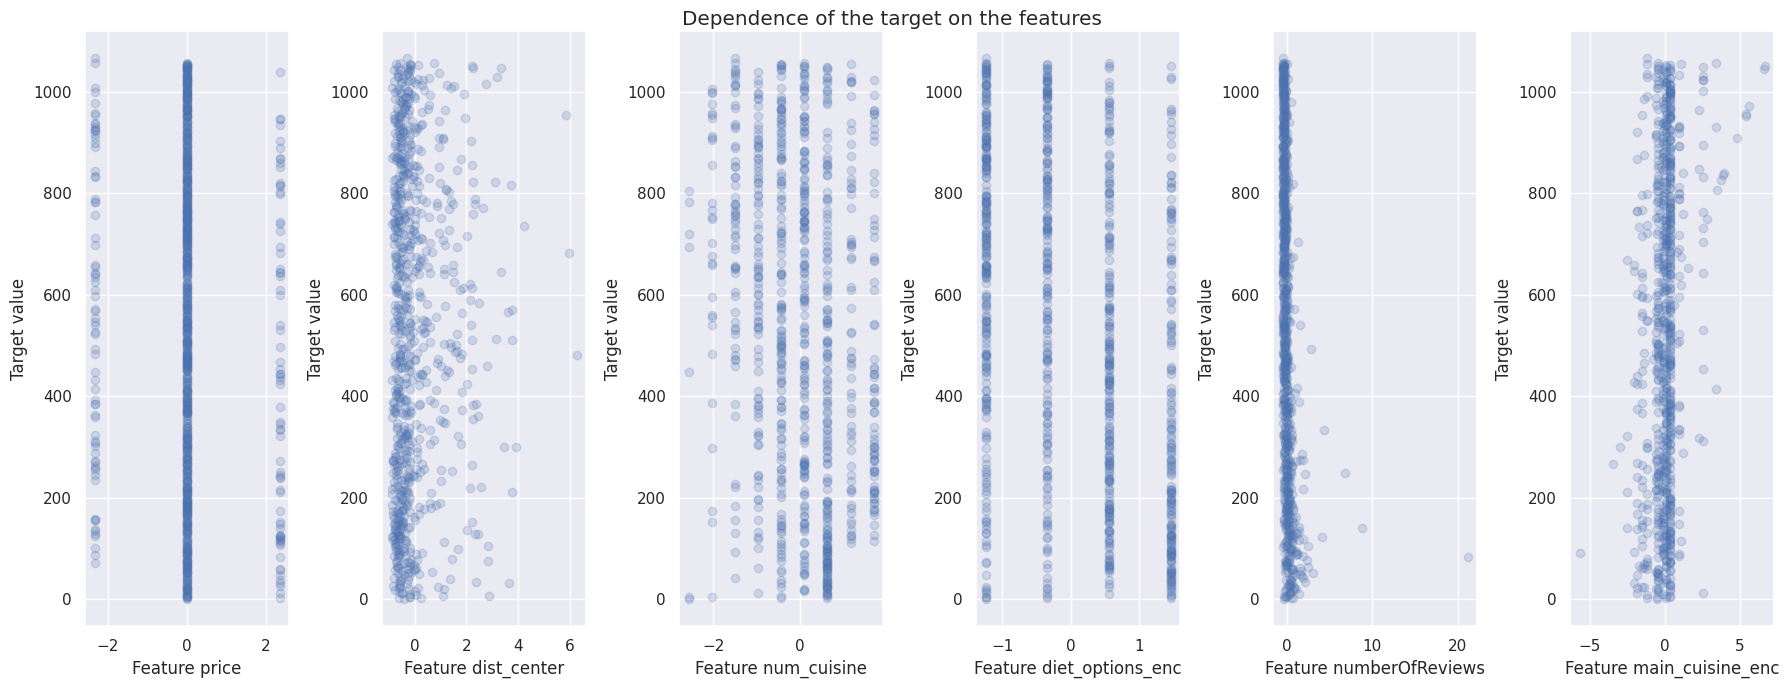

In [32]:
#сначала нарисуем график зависимости целевой переменной от каждого из признаков 
#я размещу по оси X значения признаков, а по оси y - значение целевой переменной

fig, axes = plt.subplots(figsize=(18, 7), ncols=6)
plt.suptitle('Dependence of the target on the features')
for feature in range(0, 6):
    axes[feature].scatter(X_train_sc[:, feature], y_train, alpha=0.2)
    axes[feature].set_xlabel(f'Feature {X_train.columns[feature + 1]}')
    axes[feature].set_ylabel("Target value")
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Графики не особо информативны из-за того, что признаки часто имеют дискретную структуру.

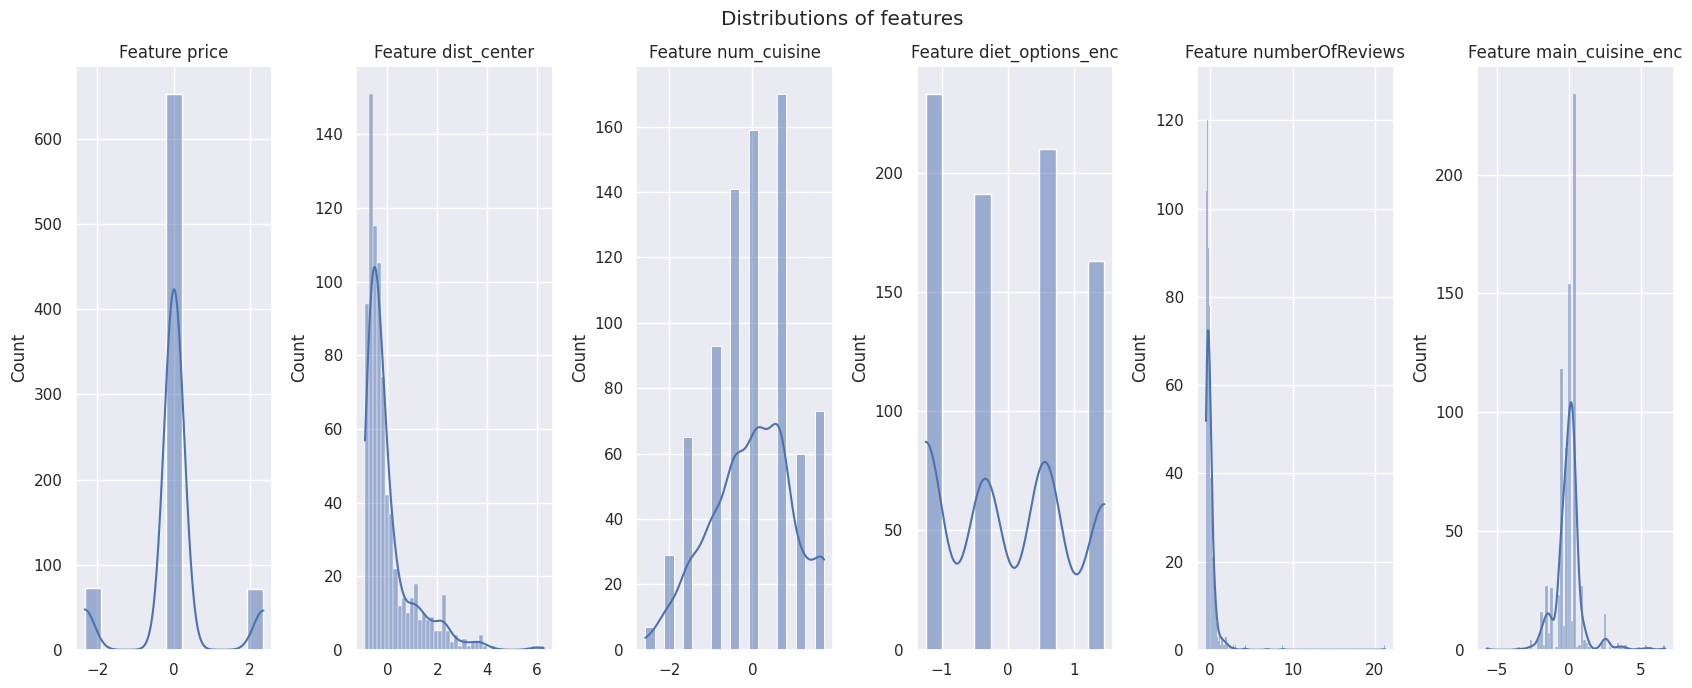

In [33]:
#посмотрим на распределение признаков 

fig, axes = plt.subplots(figsize=(17, 7), ncols=6)
plt.suptitle('Distributions of features')
for feature in range(6):
      sub2 = plt.subplot(1, 6, feature + 1)
      sns.histplot(X_train_sc[:, feature], kde=True)
      plt.title(f'Feature {X_train.columns[feature + 1]}')
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

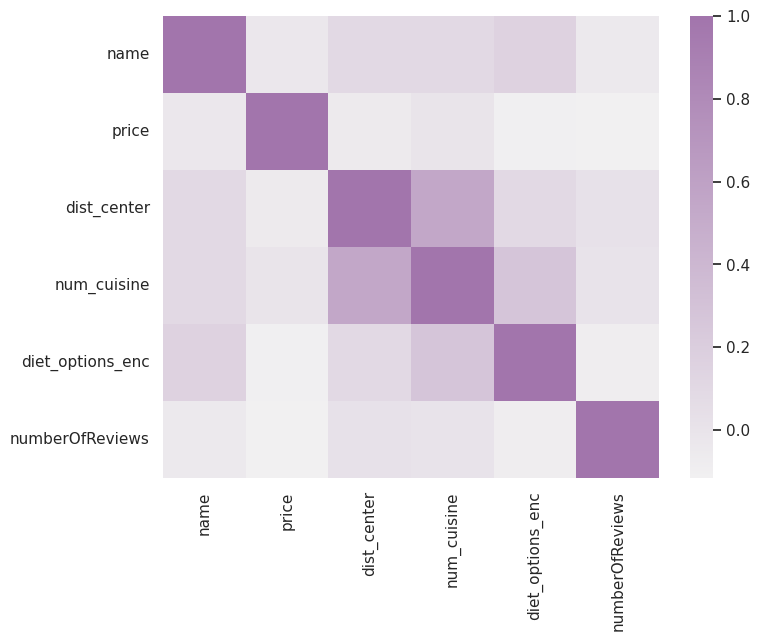

In [34]:
#теперь построим корреляции между признаками, для этого нарисуем heatmap

fig, axes = plt.subplots(figsize=(8, 6))
correlations = pd.DataFrame(X_train_sc).corr()
sns.heatmap(correlations, cmap=sns.light_palette("#a275ac", as_cmap=True), xticklabels = X_train.columns, yticklabels = X_train.columns, ax=axes)
bottom, top = axes.get_ylim() #создаем нужные нам оси, т.к. матплотлиб создает баг(
right, left = axes.get_xlim()
axes.set_ylim(bottom - 0.5)
axes.set_xlim(right, left - 0.5)
plt.show()

Видим корелляции у количества кухонь ресторана и дополнительных опций (вегетарианские, безглютеновые и пр.) и у количества кухонь и расстояния ресторана до центра.

## 5.2. Регрессия


Попробуем предсказать место в рейтинге линейной регрессией.

In [35]:
# т.к. место в рейтинге только целое, а также имеет смысл того, что чем ниже число, тем лучше ресторан, на итоговые метки нужно дважды применить сортировку

def argsort(x): 
    x = np.argsort(np.argsort(x))
    return(x)

In [36]:
model = LinearRegression()
fit = model.fit(X_train_sc, y_train) # фит
y_pred = model.predict(X_test_sc) # предикт
y_pred_sort = argsort(y_pred)
y_test_sort = argsort(y_test)
print(f"Test MAE = {MAE(y_test_sort, y_pred_sort)}")

Test MAE = 44.46


Нарисуем веса регрессии по модулю, чтобы изучить влияние на таргет.

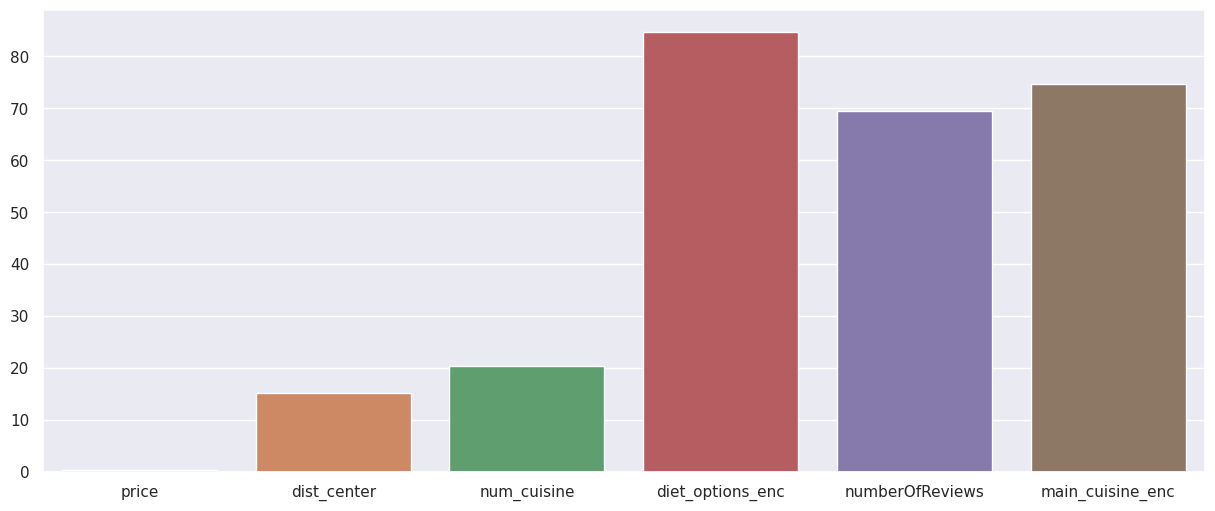

In [37]:
fig, axes = plt.subplots(figsize=(15, 6))
sns.barplot(x = X_train.columns[1:], y=np.abs(fit.coef_))
plt.show()

Как мы видим, наивысший вес в регрессии имеет количество дополнительных пищевых опций, главная кухня ресторана и количество отзывов. 

MAE вышла большая. Попробуем потестить разные трейн-тесты.

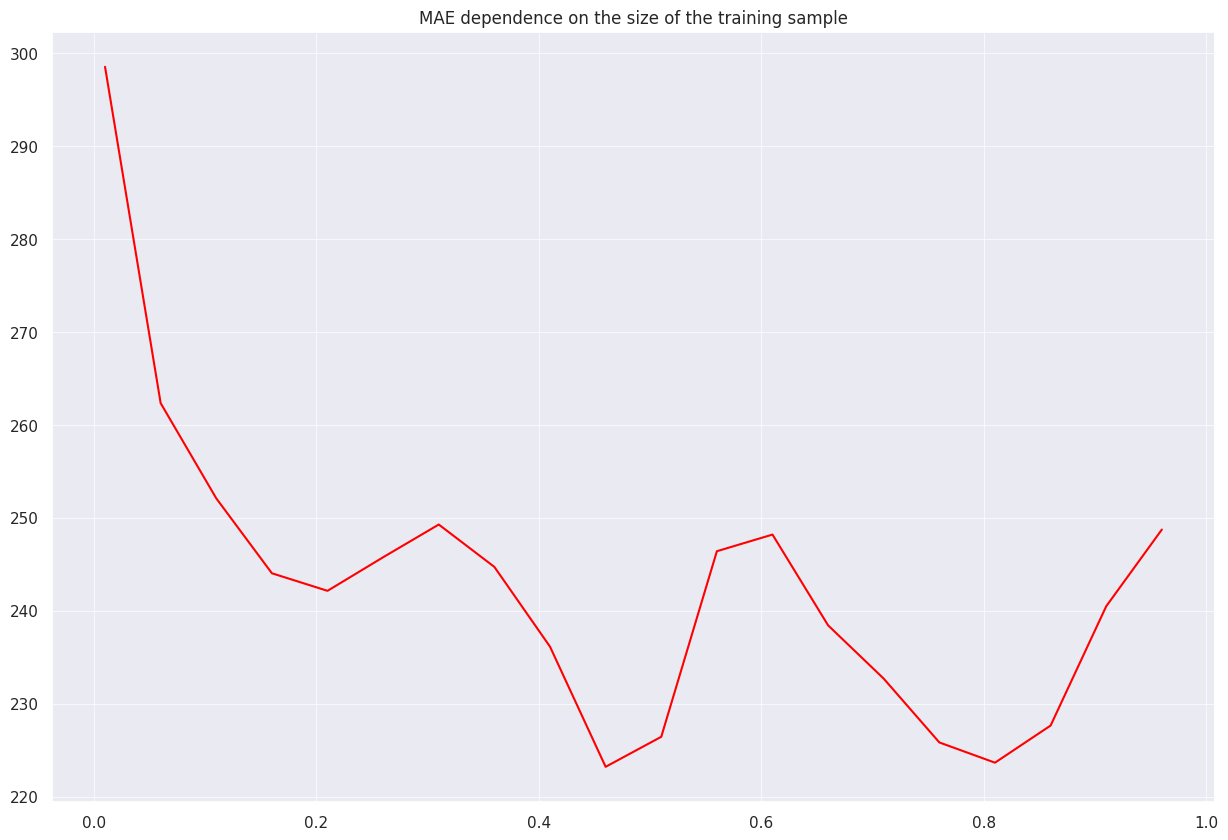

In [38]:
#обучим модель при разных размерах тест и трейн выборки и посмотрим на MSE

train_size = np.arange(0.01, 1, 0.05) #задаем как меняется размер обучающей выборки
mae_array = []
for trs in train_size:  
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size= 1 - trs, random_state = 513) #делим на трейн и тест для каждой модели 
    X_train_t, X_test_t = main_cuisine_enc(X_train_t, X_test_t, y_train_t) # кодируем
    X_train_sc_t, X_test_sc_t = scaler(X_train_t, X_test_t) #  скейлим
    model.fit(X_train_sc_t, y_train_t)
    y_pred_t = model.predict(X_test_sc_t)
    y_pred_sort_t = argsort(y_pred_t)
    y_test_sort_t = argsort(y_test_t)
    mae_array = np.append(mae_array, MAE(y_test_sort_t, y_pred_sort_t) / ((1 - trs) ))
test_optimal = np.argmin(mae_array)


#рисуем график mse от размера трейна

plt.figure(figsize=(15, 10))
plt.title('MAE dependence on the size of the training sample')
plt.grid(linestyle='-', linewidth=0.5)
plt.plot(train_size, mae_array, color='red')
plt.show()

График логично выглядит: в начале трейн слишком маленький и модели недостаточно данных, а в конце при слишком больших трейнах модель переобучается.

In [39]:
f'Оптимальный размер теста - {test_optimal / 100}'

'Оптимальный размер теста - 0.09'

In [40]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y, test_size=0.09, random_state=513, shuffle=True)
X_train_o, X_test_o = main_cuisine_enc(X_train_o, X_test_o, y_train_o) # кодируем
X_train_sc_o, X_test_sc_o = scaler(X_train_o, X_test_o) 
model.fit(X_train_sc_o, y_train_o)
y_pred_o = model.predict(X_test_sc_o)
y_pred_sort_o = np.argsort(y_pred_o)
y_test_sort_o = np.argsort(y_test_o)
print(f"Test MAE = {MAE(y_test_sort_o, y_pred_sort_o)}")

Test MAE = 28.666666666666668


Все еще получаем высокую ошибку. Попробуем использовать более сильный метод, чем регрессия, например, бустинг.

## 5.3. LightGBM

In [50]:
#подбираем  гиперпараметры, не использовала гридсерч, т.к. он почему-то очень долго работал, решила оптимизировать время и пройтись циклом

best_mae = 10000000
best_params = {} 
depths = [1, 5, 10, 15, 20, 25, 30, 50] #глубина дерева
n_estimators = [5, 10, 15, 17, 20, 23, 25, 30, 50, 100, 200] #кол-во итераций
lrs = [0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9] #лернинг рейтс
for n_estimator in n_estimators: #проходим по всем значениям, ищем те, которые уменьшают ошибку
    for lr in lrs:
        for depth in depths:
          lb = ltb.LGBMRegressor(max_depth=depth, n_estimators=n_estimator, learning_rate=lr, loss='absolute_error')
          lb.fit(X_train_sc, y_train)
          y_pred_lb = lb.predict(X_test_sc)
          new_mae = MAE(argsort(y_test), argsort(y_pred_gb))
          if new_mae < best_mae:
              best_mae = new_mae
              best_params = {'n_estimators' : n_estimator, 'lr' : lr, 'depth' : depth}
print(f'Best MAE is {best_mae} with parameters {best_params}') 

Best MAE is 21.355555555555554 with parameters {'n_estimators': 5, 'lr': 0.05, 'depth': 1}


## 5.4. Катбуст

In [43]:
#подбираем  гиперпараметры

best_mae = 10000000
best_params = {} 
iterations = [100, 300, 500, 700, 900] # кол-во итераций
l2_leaf_regs = [0.1, 0.5, 1, 1.5, 2, 5, 10] # регуляризация
bagging_temperature = [0.1, 0.5, 1, 1.5, 2, 5, 10] # бэггинг
for iteration in iterations: #проходим по всем значениям, ищем те, которые уменьшают ошибку
    for l2 in l2_leaf_regs:
        for bag in bagging_temperature:
            cb = CatBoostRegressor(max_depth=1, learning_rate=0.3, iterations=iteration, l2_leaf_reg=l2, bagging_temperature=bag, silent=True)
            cb.fit(X_train_sc, y_train)
            y_pred_cb = cb.predict(X_test_sc)
            new_mae = MAE(argsort(y_test), argsort(y_pred_cb)) 
            if new_mae < best_mae: # записываем наименьшую ошибку и параметры для нее
                best_mae = new_mae
                best_params = {'iterations' : iteration, 'l2_leaf_reg' : l2, 'bagging_temperature' : bag, 'lr': 0.3, 'depth': 1}
print(f'Best MAE is {best_mae} with parameters {best_params}')

Best MAE is 16.444444444444443 with parameters {'iterations': 900, 'l2_leaf_reg': 2, 'bagging_temperature': 0.1, 'lr': 0.3, 'depth': 1}


## 5.5. Градиентный бустинг

In [51]:
#подбираем  гиперпараметры

best_mae = 10000000
best_params = {} 
depths = [3, 5, 7, 10, 15, 20] #глубина дерева
n_estimators = [15, 17, 20, 23, 25, 50, 100] #кол-во итераций
lrs = [0.05, 0.1, 0.15, 0.5, 0.9] #лернинг рейтс
for n_estimator in n_estimators: #проходим по всем значениям, ищем те, которые уменьшают ошибку
    for lr in lrs:
        for depth in depths:
          gb = GradientBoostingRegressor(max_depth=depth, n_estimators=n_estimator, learning_rate=lr, loss='absolute_error')
          gb.fit(X_train_sc, y_train)
          y_pred_gb = gb.predict(X_test_sc)
          new_mae = MAE(argsort(y_test), argsort(y_pred_gb))
          if new_mae < best_mae:
              best_mae = new_mae
              best_params = {'n_estimators' : n_estimator, 'lr' : lr, 'depth' : depth}
print(f'Best MAE is {best_mae} with parameters {best_params}') 

Best MAE is 15.622222222222222 with parameters {'n_estimators': 25, 'lr': 0.1, 'depth': 3}


Мы сильно уменьшили ошибку до 15.6. Она, конечно, все еще не около 0, виной этому может быть недостаточное количество признаков (например, нет среднего чека, что сильно помогло бы предсказывать.). Лучшим регрессором оказался градиентный бустинг, а худшим предсказуемо линейная регрессия.

# 6. Геоданные

Нарисуем карту, которая будет показывать, какой наилучший ресторан по рейтингу находится в радиусе Х метров от точки. От каждого ресторана отложим Х метров и покрасим. Голубые кружки обозначают низкий рейтинг, а фиолетовый - высокий. Районы без покрытия = районы без ресторанов с рейтингом 4 и выше.

In [52]:
# готовим табличку

raw_table = pd.read_csv('Restaurants_1000.csv', sep=';',  encoding='cp1252', index_col='id') 
raw_table = raw_table.iloc[:-1]
t = raw_table[~raw_table['latitude'].isna() + ~raw_table['longitude'].isna()] 
t.sort_values(by = 'rankingPosition', ascending = True, inplace = True)
t

name  numberOfReviews               phone  \
id                                                                             
21281594.0            Trattoria VABENE!             79.0    +7 968 739-64-46   
19630171.0                   JustaPasta            497.0        +74954898199   
8429267.0   Sabor de la Vida Restaurant            384.0    +7 926 222-71-22   
10841351.0              Lyubov Pirogova            177.0    +7 495 120-00-97   
16805440.0        AnderSon Lva Tolstogo            108.0    +7 903 730-98-18   
...                                 ...              ...                 ...   
11045987.0               ZOO Beer&Grill            223.0    +7 495 114-51-93   
12133589.0                    Pho Point             46.0    +7 499 579-82-29   
2456475.0              Bakinskiy Bulvar            131.0    +7 499 616-73-86   
19100351.0                Zhazhda Krovi             44.0    +7 499 495-44-93   
25395656.0       Ryba Idet Na... NEREST             12.0  +7 (936) 125-37-50   

           priceLevel  rankingDenominator  rankingPosition  \
id                                                           
21281594.0        NaN             11807.0              1.0   
19630171.0   $$ - $$$             11807.0              2.0   
8429267.0        $$$$             11807.0              3.0   
10841351.0   $$ - $$$             11807.0              4.0   
16805440.0   $$ - $$$             11807.0              5.0   
...               ...                 ...              ...   
11045987.0   $$ - $$$             11807.0           1055.0   
12133589.0          $             11807.0           1056.0   
2456475.0    $$ - $$$             11807.0           1057.0   
19100351.0   $$ - $$$             11807.0           1059.0   
25395656.0          $             11807.0           1066.0   

                                       rankingString rating        type  \
id                                                                        
21281594.0      #1 of 15,850 places to eat in Moscow      5  RESTAURANT   
19630171.0      #2 of 15,850 places to eat in Moscow      5  RESTAURANT   
8429267.0       #3 of 15,850 places to eat in Moscow      5  RESTAURANT   
10841351.0      #4 of 15,850 places to eat in Moscow      5  RESTAURANT   
16805440.0      #5 of 15,850 places to eat in Moscow      5  RESTAURANT   
...                                              ...    ...         ...   
11045987.0  #1,055 of 15,850 places to eat in Moscow    3,5  RESTAURANT   
12133589.0  #1,056 of 15,850 places to eat in Moscow    4,5  RESTAURANT   
2456475.0   #1,057 of 15,850 places to eat in Moscow      4  RESTAURANT   
19100351.0  #1,059 of 15,850 places to eat in Moscow      4  RESTAURANT   
25395656.0  #1,066 of 15,850 places to eat in Moscow      5  RESTAURANT   

                                                       webUrl  ... cuisine/7  \
id                                                             ...             
21281594.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
19630171.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
8429267.0   https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
10841351.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
16805440.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
...                                                       ...  ...       ...   
11045987.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
12133589.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
2456475.0   https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
19100351.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   
25395656.0  https://www.tripadvisor.com/Restaurant_Review-...  ...       NaN   

           dietaryRestrictions/0 dietaryRestrictions/1 dietaryRestrictions/2  \
id                                                                             
21281594.0

Пишем функцию.

In [53]:
def map(matrix, radius):
    cmap = folium.Map([55.75215, 37.61819], tiles = 'cartodbpositron', zoom_start = 12)
    t = matrix

    n = t.shape[0]
    i = n
    r = radius

    # создаем цветовую карту

    linear = cm.LinearColormap(["#9f009f", "#0000af", "#00cfcf"], vmin = 1, vmax = n, caption = f"Colormap of best {n} restaurants of Moscow with radius of {r} meters") 

    linear.add_to(cmap)

    ### FROM (https://github.com/python-visualization/folium/issues/967)
    element = folium.MacroElement().add_to(cmap)
    element._template = jinja2.Template("""
        {% macro header(this, kwargs) %}   
        <style>div.leaflet-overlay-pane > svg.leaflet-zoom-animated {
            opacity: 0.5;
        }
        </style>
        {% endmacro %}
    """)
    ### END FROM

    # рисуем круги
    
    for _, row in t.iterrows(): 
        folium.Circle([row['latitude'], row['longitude']], radius = r, fill = True, fill_opacity = 1, opacity = 1, color = linear(i)).add_to(cmap)
        i -= 1

    return cmap

Нарисуем карту с радиусом 1000 м.

In [54]:
map(t, 1000)

Как мы видим, в центральных районах в любой точке находится ресторан с высоким рейтингом в радиусе километра.
Теперь нарисуем карту с радиусом 500 м. 

In [55]:
map(t, 500)

Уже где-то проглядывается синий и даже голубой.
И наконец нарисуем радиус 250 метров.

In [56]:
map(t, 250)

В центре все равно большое покрытие ресторанов с наивысшим рейтингом. На востоке и юге ресторанов с высоким рейтингом меньше всего. В отдалении от центра в основном рестораны сине-голубые, то есть уже не наилучшие.
Посмотрим еще на хитмап.

In [79]:
# функция для создания цветов хитмапы

def get_folium_color(rgb):
    res = '#'
    if rgb[0] < 16:
        res += '0'
    res += format(rgb[0], 'x')
    if rgb[1] < 16:
        res += '0'
    res += format(rgb[1], 'x')
    if rgb[2] < 16:
        res += '0'
    res += format(rgb[2], 'x')
    return res

# рисуем саму хитмапу

colormap = sns.color_palette("Paired", as_cmap=True)

cmap = folium.Map([55.75215, 37.61819], tiles='cartodbpositron', zoom_start = 12)
restaurants = t[['latitude', 'longitude']]

HeatMap(restaurants, gradient = {1 - i / 100: get_folium_color(list(int(255 * c) for c in colormap(i / 100))) for i in range(101)}, min_opacity = 0.3, blur=10, radius = 15).add_to(cmap)
cmap

Синим обозначена самая высокая плотность, светло-фиолетовым - низкая. Как мы видим, больше всего заполнение в центре на севере. Также на западе есть кластер с высокой плотностью. Меньше всего ресторанов на юго-востоке.

# 7. Математические возможности

Посчитаем попарные римановы расстояния между всеми парами ресторанов с помощью numpy. Это потенциально можно использовать для графов и создания более точных географических признаков.

In [ ]:
# переводим широту и долготу в радианы, все точки точно находятся в одной четверти Земли

stat = np.array(table1[['longitude', 'latitude']]) * np.pi / 180 
n = stat.shape[0]

# делаю тензор (ну или матрицу с ячейками в виде пар (долгота, широта)), чтобы считать расстояния между объектами, в рядах стоят одинаковые объекты

tensor = np.full(shape = (n, n, 2), fill_value = stat) 

# транспонирую тензор, теперь используем формулу расстояния вот отсюда: https://gis-lab.info/qa/great-circles.html

t_tensor = np.transpose(tensor, axes = [1, 0, 2]) 

# получается матрица смежных расстояний в км

matrix = 2 * np.arcsin((np.sin(((tensor - t_tensor) / 2)[:, :, 1]) ** 2 + np.cos(t_tensor[:, :, 1]) * np.cos(t_tensor[:, :, 1]) * np.sin(((tensor - t_tensor) / 2)[:, :, 0]) ** 2) ** 0.5) * 6372.795 

In [ ]:
matrix

array([[0.        , 4.28182696, 2.45376674, ..., 4.81142016, 2.91123045,
        4.94426524],
       [4.28299556, 0.        , 1.83771248, ..., 2.82265803, 1.48821497,
        2.44842706],
       [2.4541043 , 1.8374662 , 0.        , ..., 3.28190146, 0.74551779,
        2.95677363],
       ...,
       [4.81296072, 2.82198959, 3.28151654, ..., 0.        , 2.54541475,
        5.25952554],
       [2.91192279, 1.48817316, 0.74551517, ..., 2.54570035, 0.        ,
        3.25222572],
       [4.94432674, 2.44895844, 2.95691554, ..., 5.26193473, 3.25270993,
        0.        ]])

Получили матрицу. В дальнейшем расстояния можно было бы использовать для построения ресторанных маршрутов и более детального географического анализа.

# 8. Графы

Построим граф, вершинами которого будут рестораны, а ребрами - кухни у каждого ресторана. Таким образом мы сможем посмотреть на то, каких кухонь больше всего, и через сколько шагов можно "дойти" от одной кухни к другой.

In [17]:
# готовим табличку

restaurants = table1['name'].iloc[:]
cuisines = table1.iloc[:, 13:21]
restaurants = restaurants[~np.all(cuisines == 'Not stated', axis = 1)] # обрабатываем пропуски
cuisines = cuisines[~np.all(cuisines == 'Not stated', axis = 1)]
res = set(restaurants)
cus = set()
for i in range(8):
    cus |= set(cuisines.iloc[:, i].unique()) # уникальные значения
cus.discard('Not stated')

Создаем граф.

In [18]:
G = nx.Graph()
G.add_nodes_from(res, bipartite = 0) # вершины
G.add_nodes_from(cus, bipartite = 1)

for i in range(restaurants.shape[0]):
    for j in range(8):
        if cuisines.iloc[i, j] != 'Not stated':
            G.add_edge(restaurants.iloc[i], cuisines.iloc[i, j]) # ребра

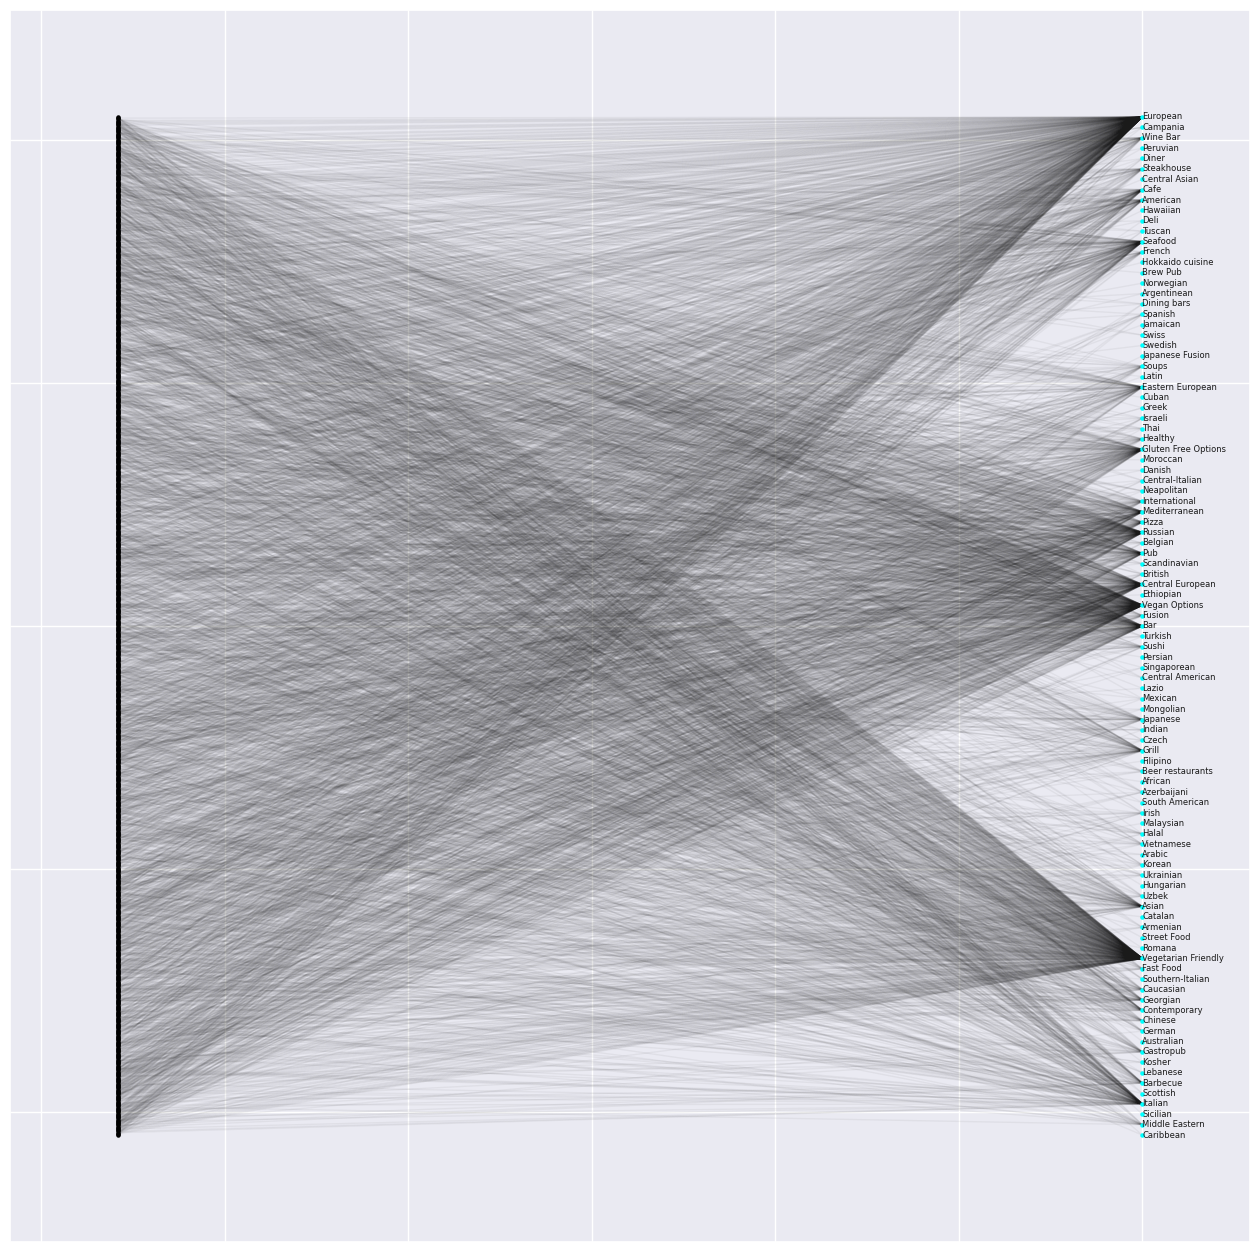

In [19]:
# рисуем, справа кухни

fig = plt.figure(figsize = (16, 16))
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw_networkx_nodes(G, pos, nodelist = res, node_size = 5, node_color = '#000000') # рисуем вершины
nx.draw_networkx_nodes(G, pos, nodelist = cus, node_size = 5, node_color = '#00ffff')
nx.draw_networkx_labels(G, pos, labels = {n: n for n in cus}, font_size = 6, horizontalalignment = 'left') # подписываем
nx.draw_networkx_edges(G, pos, alpha = 0.05, node_size = 5) # рисуем ребра
plt.show()

Чем темнее пучок, тем чаще встречается кухня (в большем кол-ве ресторанов).
Теперь попробуем исключить некоторые ярлыки из списка кухонь, которые не совсем имеют отношение к анализу.

In [20]:
# список таких ярлыков

taboo = set(['Not stated', 'Vegetarian Friendly', 'Bar', 'Wine Bar', 'Cafe', 'Gluten Free Options', 'Vegan Options'])

res2 = res.copy()
cus2 = cus - taboo

# строим граф

G2 = nx.Graph()
G2.add_nodes_from(res2, bipartite = 0)
G2.add_nodes_from(cus2, bipartite = 1)

for i in range(restaurants.shape[0]):
    flag = False
    for j in range(8):
        if cuisines.iloc[i, j] not in taboo: # проверка, что не в листе неинтересующих нас
            flag = True
            G2.add_edge(restaurants.iloc[i], cuisines.iloc[i, j])

# убираем лишние вершины

big_comp = []
for comp in nx.connected_components(G2):
    if len(comp) > len(big_comp):
        big_comp = comp
to_remove = []
for comp in nx.connected_components(G2):
    if len(comp) < len(big_comp):
        to_remove.append(comp)
for comp in to_remove:
    res2 -= set(comp)
    G2.remove_nodes_from(comp)

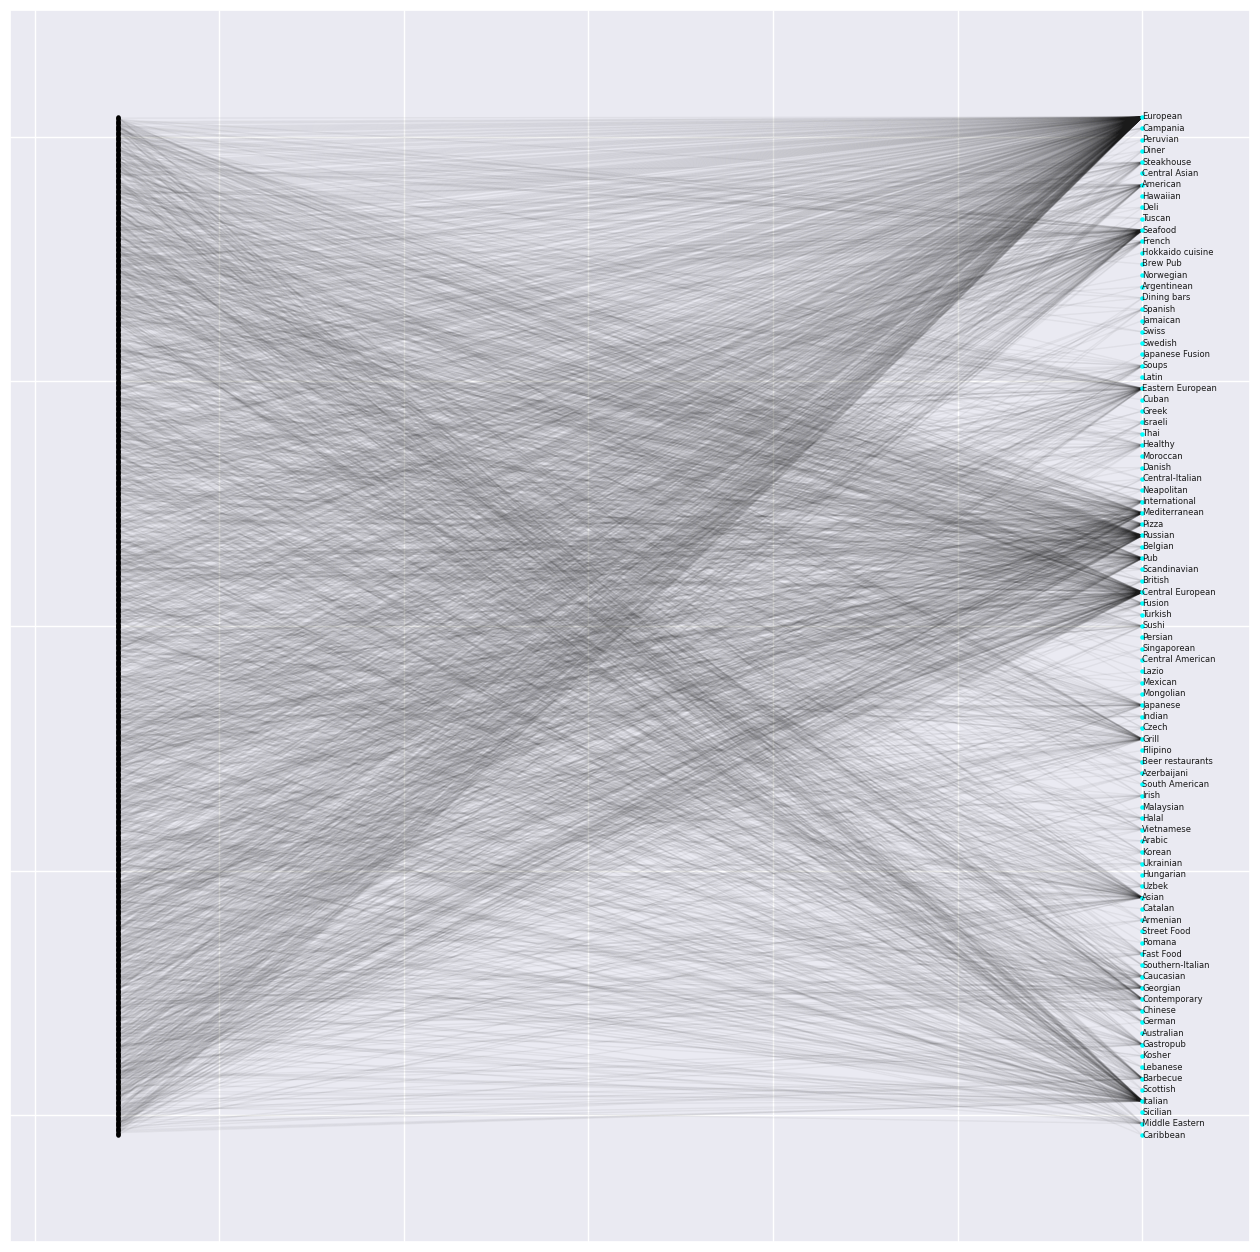

In [21]:
# рисуем новый граф

fig = plt.figure(figsize = (16, 16))
top2 = nx.bipartite.sets(G2)[0]
pos2 = nx.bipartite_layout(G2, top2)
nx.draw_networkx_nodes(G2, pos2, nodelist = res2, node_size = 5, node_color = '#000000')
nx.draw_networkx_nodes(G2, pos2, nodelist = [n for n in cus2 if n in pos2], node_size = 5, node_color = '#00ffff')
nx.draw_networkx_labels(G2, pos2, labels = {n: n for n in cus2 if n in pos2}, font_size = 6, horizontalalignment = 'left')
nx.draw_networkx_edges(G2, pos2, alpha = 0.05, node_size = 5)
plt.show()

Видим, что популярнее всего Европейская, Морепродукты, Русская, Гриль, Азиатская кухни.

# 9. SQL

Попробуем использовать SQL для работы с нашим датасетом. 

In [90]:
tablesql = table1.rename(columns={'cuisine/0' : 'cuisine0'})

Загружаем всю табличку в SQL.

In [91]:
table_sql = duckdb.query("SELECT * FROM tablesql")
table_sql

┌─────────────────────┬─────────────────┬───┬──────────────────────┬──────────────────────┬───────────────┐
│        name         │ numberOfReviews │ … │ mean_price_by_cuis…  │ mean_ranking_by_cu…  │     label     │
│       varchar       │     double      │   │        double        │        double        │    varchar    │
├─────────────────────┼─────────────────┼───┼──────────────────────┼──────────────────────┼───────────────┤
│ Soup Ñafe           │           638.0 │ … │   1.8085106382978724 │    568.8297872340426 │ Overpriced    │
│ ROMBUS CAFE and BAR │           100.0 │ … │   1.9946524064171123 │               562.25 │ Overpriced    │
│ Severyane           │           429.0 │ … │   1.9946524064171123 │               562.25 │ Overpriced    │
│ El Gaucho           │           162.0 │ … │   2.1666666666666665 │    682.3333333333334 │ Overpriced    │
│ Osteria Mario       │           192.0 │ … │   2.0303030303030303 │    519.2797619047619 │ Fairly priced │
│ Bolshoi Restaurant  │     

Топ-10 самых дешевых ресторанов европейской кухни:

In [93]:
duckdb.query("SELECT name FROM table_sql WHERE table_sql.cuisine0 = 'European' ORDER BY price ASC LIMIT 10")

┌──────────────────────────────────────┐
│                 name                 │
│               varchar                │
├──────────────────────────────────────┤
│ Nebar                                │
│ Kitchen Polly                        │
│ Hinkali Gali                         │
│ Culinary Shop Of Brothers Karavaevyh │
│ Roaster coffee                       │
│ Hvoya                                │
│ Mu-Mu                                │
│ Hinkali Gali                         │
│ Pelmennaya Lavka                     │
│ Zhadina-Govyadina                    │
├──────────────────────────────────────┤
│               10 rows                │
└──────────────────────────────────────┘

Среднее место в рейтинге ресторанов с азиатской кухней:

In [95]:
duckdb.query("SELECT AVG(rankingPosition) FROM table_sql WHERE table_sql.cuisine0 == 'Asian'")

┌────────────────────────┐
│ avg("rankingPosition") │
│         double         │
├────────────────────────┤
│               605.4375 │
└────────────────────────┘

Среднее место в рейтинге ресторанов с европейской кухней:

In [96]:
duckdb.query("SELECT AVG(rankingPosition) FROM table_sql WHERE table_sql.cuisine0 == 'European'")

┌────────────────────────┐
│ avg("rankingPosition") │
│         double         │
├────────────────────────┤
│                 562.25 │
└────────────────────────┘

Среднее место в рейтинге ресторанов с большим кол-вом отзывов:

In [97]:
duckdb.query("SELECT AVG(rankingPosition) FROM table_sql WHERE numberOfReviews > 500")

┌────────────────────────┐
│ avg("rankingPosition") │
│         double         │
├────────────────────────┤
│     160.46153846153845 │
└────────────────────────┘

Группируем по кухне и считаем средний рейтинг:

In [98]:
duckdb.query("SELECT ANY_VALUE(rankingPosition), cuisine0 FROM table_sql WHERE rankingPosition > 500 GROUP BY cuisine0")

┌──────────────────────────────┬───────────────┐
│ any_value("rankingPosition") │   cuisine0    │
│            double            │    varchar    │
├──────────────────────────────┼───────────────┤
│                        504.0 │ Wine Bar      │
│                        502.0 │ Russian       │
│                        510.0 │ Japanese      │
│                        515.0 │ European      │
│                        518.0 │ Contemporary  │
│                        529.0 │ Georgian      │
│                        530.0 │ French        │
│                        523.0 │ Bar           │
│                        506.0 │ Italian       │
│                        512.0 │ American      │
│                          ·   │    ·          │
│                          ·   │    ·          │
│                          ·   │    ·          │
│                        847.0 │ Lebanese      │
│                        952.0 │ Soups         │
│                        955.0 │ Central Asian │
│                   

# 10. Регулярные выражения и работа с requests

Эта функция ищет количество употребления позитивных слов и негативных слов на страничке отзывов ресторана, чтобы можно было не читая отзывы, понять их общую эмоциональную окраску. Я советую использовать ссылки яндекса, т.к. на некоторых сайтах плохо работает html-декодинг.

In [22]:
def reg(link):

    # открываем ссылку

    url = link
    response = urllib.request.urlopen(url)
    html = response.read().decode()

    # считаем положительные слова

    positive_words = ['хорош', ' вкусн', 'отличн', 'супер', 'лучш']
    positive_count = 0
    for word in positive_words:
        pattern = re.compile(word, re.IGNORECASE)
        matches = pattern.findall(html)
        positive_count += len(matches)

    # считаем негативные слова

    negative_words = ['плох', 'ужас', 'невкусн', 'не понравил', 'худш']
    negative_count = 0
    for word in negative_words:
        pattern = re.compile(word, re.IGNORECASE)
        matches = pattern.findall(html)
        negative_count += len(matches)

    # результаты
    
    print("Количество положительных слов для ресторана:", positive_count)
    print("Количество отрицательных слов для ресторана:", negative_count)


In [23]:
reg('https://yandex.ru/maps/org/trattoriya_vabene_/238294571168/reviews/?ll=37.578517%2C55.763653&tab=reviews&z=13')

Количество положительных слов для ресторана: 148
Количество отрицательных слов для ресторана: 4


In [25]:
reg('https://yandex.ru/maps/org/grusha/225669345210/reviews/?ll=37.650109%2C55.754010&tab=reviews&z=16.2') # отзывы на грушу

Количество положительных слов для ресторана: 94
Количество отрицательных слов для ресторана: 4


Downloading...
From: https://drive.google.com/uc?id=1yR9kp531mq0r6eEbLjXHXK0WE7QEWSKL
To: /content/grusha.jpeg
100% 6.87k/6.87k [00:00<00:00, 17.6MB/s]


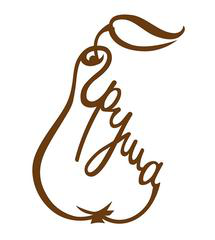

In [37]:
!gdown 1yR9kp531mq0r6eEbLjXHXK0WE7QEWSKL 
grusha = Image.open('/content/grusha.jpeg')
grusha

Спасибо, что посмотрели мой проект!